In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry
import math
import numpy

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

Using matplotlib backend: <object object at 0x0000019C8F4DE2E0>


# Lab 5 Report

## Ian Eykamp

## Pre-Lab Calculations

In [3]:
Vg = 18 * units.volt
Vout = 10 * units.volt
M = Vout / Vg
Rload = 5 * units.ohm
Pout = 20 * units.watt
Iout = Pout / Vout
D = 0.35
alpha = 0.80
a = Vg / Vout * D / (np.sqrt(alpha) - D)
fs = 50 * units.kilohertz
Ts = 1 / fs
Lcrit = 1 / (M + 1) ** 2 * Rload * Ts / 2
L = alpha * Lcrit
Ipeak = 2 / np.sqrt(alpha) * (M + 1) * Vout / Rload

print(f"Winding ratio a = N1 / N2: {a}")
print(f"Inductor value L: {L.to('microhenry')}")
print(f"Peak current Ipeak: {Ipeak.to('amp')}")

Winding ratio a = N1 / N2: 1.16
Inductor value L: 16.53 µH
Peak current Ipeak: 6.96 A


## PLECS Model
![Flyback converter schematic](flyback_converter_schematic_1.png)
**Figure 1.** Flyback converter schematic.

The PI control loop shown in the brown box was used to set the COMP voltage such that the output voltage matches the target voltage of 10V.The gain of 100 was chosen by trial and error. V_COMP stabilizes quickly at 2.35V, yielding a duty cycle of 32%.

I placed the output current loop north of the input current loop in the schematic. This makes the most sense to me, since it topographically shows the voltage increase in the right hand circuit during boost operation.

The peak current matches very closely with the equations. It is a higher peak current than observed under the buck configuration. This corroborates the equations we derived in lessons 2 and 8a. For the buck converter, $I_{peak} = \frac{2}{\sqrt{\alpha}} \cdot \frac{V_{out}}{R_{load}}$. For the flyback converter, we have $I_{peak} = \frac{2}{\sqrt{\alpha}} \cdot (M + 1) \cdot \frac{V_{out}}{R_{load}}$ in discontinuous conduction mode. There is a similar factor of $(M + 1)$ in the equations for $I_{peak}$ in continuous conduction mode, where $0 \lt M \lt \infty$.

## Oscilloscope Data

In [4]:
# Task 3 csv files: Vshunt and Vdrain
(df_task1_4V, tspan, tstep) = helper.read_rigol_csv("scope_data/Task1-1.csv", ch1 = "Vsh_4V", ch2 = "Vd_4V", shift = -0.75e-6)
(df_task1_7V, tspan, tstep) = helper.read_rigol_csv("scope_data/Task1-2.csv", ch1 = "Vsh_7V", ch2 = "Vd_7V")
(df_task1_9V, tspan, tstep) = helper.read_rigol_csv("scope_data/Task1-3.csv", ch1 = "Vsh_9V", ch2 = "Vd_9V")

# Task 4 csv files: Vinj and Vdd
(df_task2_4V, tspan, tstep) = helper.read_rigol_csv("scope_data/Task2-1.csv", ch1 = "Vinj_4V", ch2 = "Vdd_4V")
(df_task2_7V, tspan, tstep) = helper.read_rigol_csv("scope_data/Task2-2.csv", ch1 = "Vinj_7V", ch2 = "Vdd_7V", shift = 2e-6)
(df_task2_9V, tspan, tstep) = helper.read_rigol_csv("scope_data/Task2-3.csv", ch1 = "Vinj_9V", ch2 = "Vdd_9V", shift = 8e-6)

# Combine all variables into one for convenience
df = df_task1_4V.set_index("t").join([df_task1_7V.set_index("t"), df_task1_9V.set_index("t"), df_task2_4V.set_index("t"), df_task2_7V.set_index("t"), df_task2_9V.set_index("t")]).reset_index()

(-7e-07, 1.6e-05, 1.92e-05)
(1.7e-06, 1.6e-05, 2.18e-05)
(3.5e-06, 1.6e-05, 2.35e-05)


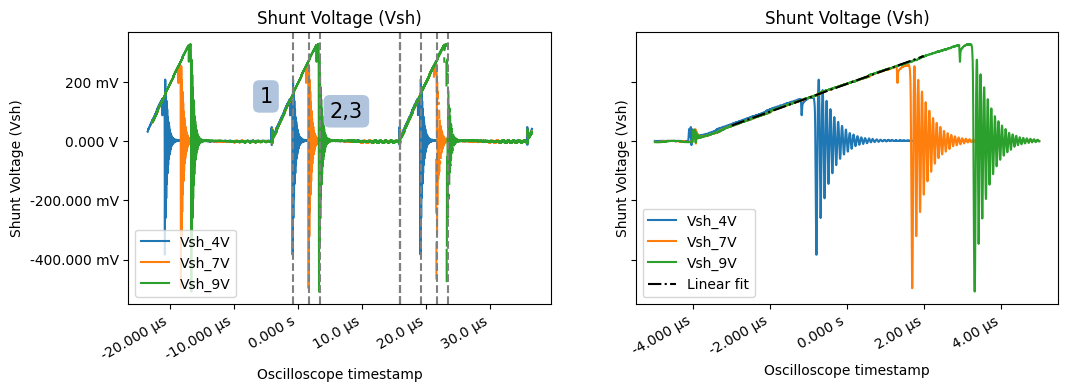

In [5]:
# Vshunt
df_envelope = df # df[(df["t"] > -2e-6) & (df["t"] < 2e-6)]
df_zoom = df[(df["t"] > -5e-6) & (df["t"] < 5e-6)]

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = True, figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = "Shunt Voltage (Vsh)", ax = ax1)
ax1.plot(df_envelope["t"], df_envelope["Vsh_4V"], label = "Vsh_4V")
ax1.plot(df_envelope["t"], df_envelope["Vsh_7V"], label = "Vsh_7V")
ax1.plot(df_envelope["t"], df_envelope["Vsh_9V"], label = "Vsh_9V")
ax1.legend(loc = "lower left")
ax1.annotate('1', xy=(-6e-6, 150e-3), size=15, va="center", bbox=dict(boxstyle="round", fc="lightsteelblue", ec="none"))
ax1.annotate('2,3', xy=(5e-6, 100e-3), size=15, va="center", bbox=dict(boxstyle="round", fc="lightsteelblue", ec="none"))


helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = "Shunt Voltage (Vsh)", ax = ax2)
ax2.plot(df_zoom["t"], df_zoom["Vsh_4V"], label = "Vsh_4V")
ax2.plot(df_zoom["t"], df_zoom["Vsh_7V"], label = "Vsh_7V")
ax2.plot(df_zoom["t"], df_zoom["Vsh_9V"], label = "Vsh_9V")

Vshunt = np.array([150e-3, 260e-3, 330e-3])
# ax2.axhline(y = Vshunt[0], color = "black", linestyle = "dashed", label = f"Vsh = {int(Vshunt[0] * 1e3)}mV")
# ax2.axhline(y = Vshunt[1], color = "black", linestyle = "dashed", label = f"Vsh = {int(Vshunt[1] * 1e3)}mV")
# ax2.axhline(y = Vshunt[2], color = "black", linestyle = "dashed", label = f"Vsh = {int(Vshunt[2] * 1e3)}mV")
ax2.legend(loc = "lower left")

# plot duty cycle markers
duty_cycle_ts = [(-0.7e-6, 16e-6, 19.2e-6), (1.7e-6, 16e-6, 21.8e-6), (3.5e-6, 16e-6, 23.5e-6)]
for duty_cycle_marker_set in duty_cycle_ts:
    print(duty_cycle_marker_set)
    for duty_cycle_marker in duty_cycle_marker_set:
        ax1.axvline(x = duty_cycle_marker, linestyle = "dashed", color = "grey")
        pass

linear_ts = (-3e-6, 2e-6)
df_linreg = df_task1_9V[(df_task1_9V["t"] > linear_ts[0]) & (df_task1_9V["t"] < linear_ts[1])]

x = df_linreg["t"]
y = df_linreg["Vsh_9V"]
A = np.vstack([x, np.ones(len(x))]).T
a, b = np.linalg.lstsq(A, y, rcond=None)[0]
ax2.plot(df_linreg["t"], df_linreg["t"] * a + b, linestyle = "dashdot", color = "black", label = "Linear fit")
ax2.legend(loc = "lower left")

* **Region 1:** Inductor is charging up from input power source Ig.
* **Region 2:** Inductor is discharging into output into load resistor and capacitor.
* **Region 3:** Inductor no longer discharging (ran out of current). Output voltage is maintained by capacitor.

The shunt voltage behavior is very similar to the buck converter, including the irregularities at the start and end of the current ramp (around -4us and +3us on the Vsh_9V plot). Perhaps these bumps are caused by the leakage inductances on the transformer. This makes sense, because they oppose the change in current flow by a small amount near the start and end of the charging cycle of the magnetizing inductor. However, this may not be the case, because we saw identical behavior for the buck converter, which does not have separate leakage inductances.

In any case, we see a steady current ramp with identical slope for all output voltage values until the peak current is reached, after which we see large-amplitude ringing with period ~100ns, and time constant ~1us, and initial amplitude +10% - 200% of the peak current.

In [6]:
duty_cycle_list = []
for i, duty_cycle_marker_set in enumerate(duty_cycle_ts):
    this_duty_cycle = 1 - (duty_cycle_marker_set[1] - duty_cycle_marker_set[0]) / ((duty_cycle_marker_set[2] - duty_cycle_marker_set[0]))
    duty_cycle_list.append(this_duty_cycle)

duty_cycle = np.array(duty_cycle_list)
# print(f"Duty cycle for 9V output: {(duty_cycle * 100).round(1)}%")

Rload = 5 # ohms
Rshunt = 0.05 # ohms
Vin = 17.9 # V
Vout = 9.00 # V
dIdt = a / Rshunt
Vinductor = Vin # minus
L = Vinductor / dIdt
print(f"L: {si_format(L, precision = 2)}H")
# print(f"dI/dt: {si_format(dIdt, precision = 2)}A/s")

output_voltage = np.array([4.01, 7.00, 9.00]) # V
output_current = output_voltage / Rload
input_current = np.array([0.28, 0.77, 1.25]) # A
power_efficiency = (output_voltage * output_current) / (Vin * input_current)
df_to_print = pd.DataFrame({"Output Voltage (V)": output_voltage, "Input Current (A)": input_current, 
              "Vshunt (V)": Vshunt, "I_peak (A)": Vshunt / Rshunt, 
              "duty cycle (%)": (duty_cycle * 100).round(1), "efficiency (%)": (power_efficiency * 100).round(1)})
df_to_print.set_index("Output Voltage (V)", inplace = True)
print(df_to_print)


L: 19.10 µH
                    Input Current (A)  Vshunt (V)  I_peak (A)  duty cycle (%)  \
Output Voltage (V)                                                              
4.01                             0.28        0.15         3.0            16.1   
7.00                             0.77        0.26         5.2            28.9   
9.00                             1.25        0.33         6.6            37.5   

                    efficiency (%)  
Output Voltage (V)                  
4.01                          64.2  
7.00                          71.1  
9.00                          72.4  


The magnetizing inductance of the transformer is ~19.1uH. The efficiency is 65%-75%, voltage-dependent, and the peak current matches the simulation quite nicely (comparing the 9V measured peak current with the 10V simulated peak current).

(0.0, 55.0)

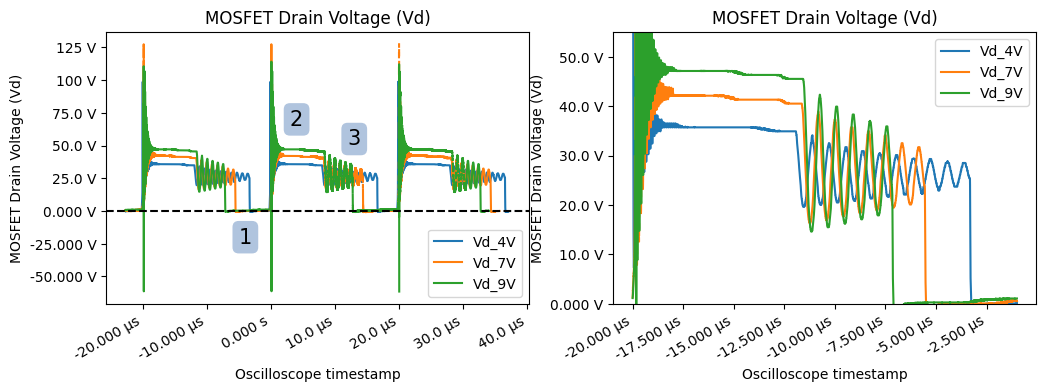

In [7]:
# Task 3 csv files: Vshunt and Vdrain
(df_task1_4V, tspan, tstep) = helper.read_rigol_csv("scope_data/Task1-1.csv", ch1 = "Vsh_4V", ch2 = "Vd_4V", shift = 0)
(df_task1_7V, tspan, tstep) = helper.read_rigol_csv("scope_data/Task1-2.csv", ch1 = "Vsh_7V", ch2 = "Vd_7V", shift = -1.6e-6)
(df_task1_9V, tspan, tstep) = helper.read_rigol_csv("scope_data/Task1-3.csv", ch1 = "Vsh_9V", ch2 = "Vd_9V", shift = -3.2e-6)

# Task 4 csv files: Vinj and Vdd
(df_task2_4V, tspan, tstep) = helper.read_rigol_csv("scope_data/Task2-1.csv", ch1 = "Vinj_4V", ch2 = "Vdd_4V")
(df_task2_7V, tspan, tstep) = helper.read_rigol_csv("scope_data/Task2-2.csv", ch1 = "Vinj_7V", ch2 = "Vdd_7V")
(df_task2_9V, tspan, tstep) = helper.read_rigol_csv("scope_data/Task2-3.csv", ch1 = "Vinj_9V", ch2 = "Vdd_9V")

# Combine all variables into one for convenience
df = df_task1_4V.set_index("t").join([df_task1_7V.set_index("t"), df_task1_9V.set_index("t"), df_task2_4V.set_index("t"), df_task2_7V.set_index("t"), df_task2_9V.set_index("t")]).reset_index()

# adjust vertical voltages because of AC coupling
df["Vd_4V"] = df["Vd_4V"] + 8.5 # V
df["Vd_7V"] = df["Vd_7V"] + 8.5 # V
df["Vd_9V"] = df["Vd_9V"] - 16.5 # V

# for later
Vout_vdd = [4.017, 6.99, 9.00]
df["Vdd_4V"] = df["Vdd_4V"] + 4.017 # V
df["Vdd_7V"] = df["Vdd_7V"] + 6.99 # V
df["Vdd_9V"] = df["Vdd_9V"] + 9.00 # V

# Vdrain
df_envelope = df
df_zoom = df[(df["t"] > -20e-6) & (df["t"] < -1e-6)]

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = False, figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "MOSFET Drain Voltage (Vd)", "V", title = "MOSFET Drain Voltage (Vd)", ax = ax1)
ax1.plot(df_envelope["t"], df_envelope["Vd_4V"], label = "Vd_4V")
ax1.plot(df_envelope["t"], df_envelope["Vd_7V"], label = "Vd_7V")
ax1.plot(df_envelope["t"], df_envelope["Vd_9V"], label = "Vd_9V")
ax1.legend(loc = "lower right")
ax1.annotate('1', xy=(-5e-6, -20), size=15, va="center", bbox=dict(boxstyle="round", fc="lightsteelblue", ec="none"))
ax1.annotate('2', xy=(3e-6, 70), size=15, va="center", bbox=dict(boxstyle="round", fc="lightsteelblue", ec="none"))
ax1.annotate('3', xy=(12e-6, 55), size=15, va="center", bbox=dict(boxstyle="round", fc="lightsteelblue", ec="none"))
ax1.axhline(y = 0, color = "black", linestyle = "dashed", label = "t = 0s")

helper.axes_labels("Oscilloscope timestamp", "s", "MOSFET Drain Voltage (Vd)", "V", title = "MOSFET Drain Voltage (Vd)", ax = ax2)
ax2.plot(df_zoom["t"], df_zoom["Vd_4V"], label = "Vd_4V")
ax2.plot(df_zoom["t"], df_zoom["Vd_7V"], label = "Vd_7V")
ax2.plot(df_zoom["t"], df_zoom["Vd_9V"], label = "Vd_9V")
Vdrain = np.array([36, 42, 47])
# ax2.axhline(y = Vdrain[0], color = "black", linestyle = "dashed", label = f"Vdr = {int(Vdrain[0])}V")
# ax2.axhline(y = Vdrain[1], color = "black", linestyle = "dashed", label = f"Vdr = {int(Vdrain[1])}V")
# ax2.axhline(y = Vdrain[2], color = "black", linestyle = "dashed", label = f"Vdr = {int(Vdrain[2])}V")
ax2.legend(loc = "upper right")
ax2.set_ylim(0, 55)

#### Same regions as before
* **Region 1:** Inductor is charging up from input power source Ig.
* **Region 2:** Inductor is discharging into output into load resistor and capacitor.
* **Region 3:** Inductor no longer discharging (ran out of current). Output voltage is maintained by capacitor.

*I adjusted the oscilloscope values such that the drain voltage was close to ground in region 1. I did this initially thinking that we had taken data in AC coupling mode, but I just remembered it was in DC coupling mode the whole time. What's going on? I adjusted the 4V and 7V traces by the same amount (+8.5V) and the 9V trace by -16.5V.*

For flyback converter hardware design, it is important to pay attention to the maximum voltage reached by the ripple on the MOSFET drain, such that components with appropriate ratings can be selected. The maximum voltage here is 125V. Beat told me that we will be designing snubber circuits to reduce this ripple and allow for lower-rated (thus possibly more efficient) components.

The ringing following the transition from 1 to 2 has the same period (~100ns) as before (not visible on the plot, but I zoomed in to estimate it).

In region 3, the ringing has a period of just under 2us, a voltage-dependent amplitude on the order of 10V, and a large time constant.

Curiously, region 2 lasts for the same duration for any output voltage, despite the lower peak voltage and earlier charging cutoff. This is probably because a higher output voltage depletes the inductor current faster, in proportion to the peak current being higher to begin with.

In region 2, the MOSFET drain voltage is 36-47V, depending on the output voltage. It decreases very slightly over time, following an interesting stair-step pattern. I am not sure if this is caused by a physical phenomonon such as a variation in temperature or if it is an artifact of the oscilloscope. In any case, `Vin - Vdrain` is the voltage observed across the left side of the ideal transformer as it was discharging. The voltage across the right hand side is the output voltage of 4V, 7V, or 9V. Thus, the turns ratio of the transformer is given by $a = \frac{(V_g - V_{drain})}{V_{out}}$.

This method does not yield consistent results. Therefore, I calculate the winding ratio $a$ using the equation $a = \frac{V_g}{V_{out}} \cdot \frac{D}{\sqrt{\alpha} - D}$, where $\alpha = \frac{L}{L_{crit}}$, with $L_{crit} = \frac{1}{(1 - M)^2} \cdot R_{load} \cdot \frac{T_s}{2}$. This yields a more reasonable, less output-dependent result of $a \approx 1.3 \pm 0.1$ turns.

In [8]:
Rload = 5 # Ohm

a_formula = []
a_ratio = []
for i, duty_cycle_marker_set in enumerate(duty_cycle_ts):
    Ts = duty_cycle_marker_set[2] - duty_cycle_marker_set[0]
    Fs = 1 / Ts

    M = output_voltage[i] / Vin
    Lcrit = 1 / (M + 1) ** 2 * Rload * Ts / 2
    alpha = L / Lcrit
    D = duty_cycle[i]
    Vout = output_voltage[i]
    a = Vin / Vout * D / (np.sqrt(alpha) - D)
    # print(f"M: {M}, alpha: {alpha}, D: {D}, Vin: {Vin}, Vout: {Vout}, Ts: {Ts}, a:{a}")
    a_formula.append(a)

    Vleft = Vin - Vdrain[i]
    Vright = output_voltage[i]
    a_ratio.append(-Vleft / Vright)
    # print(f"Vin: {Vin}, Vdrain: {Vdrain[i]}, output_voltage: {output_voltage[i]}, Vleft: {Vleft}, Vright: {Vright}, a:{a_ratio}")

df_to_print = pd.DataFrame({"Output Voltage (V)": output_voltage, "Vdrain (V)": Vdrain, "a (voltage ratio)": a_ratio, 
                            "Duty cycle (calculated above)": duty_cycle, "a (formula)": a_formula})
df_to_print.set_index("Output Voltage (V)", inplace = True)
print(df_to_print)

                    Vdrain (V)  a (voltage ratio)  \
Output Voltage (V)                                  
4.01                        36           4.513716   
7.00                        42           3.442857   
9.00                        47           3.233333   

                    Duty cycle (calculated above)  a (formula)  
Output Voltage (V)                                              
4.01                                     0.160804     1.201141  
7.00                                     0.288557     1.296698  
9.00                                     0.375000     1.346753  


Capacitance Value for 4.017V: 4.92 µF
Capacitance Value for 6.99V: 3.73 µF
Capacitance Value for 9.0V: 3.10 µF


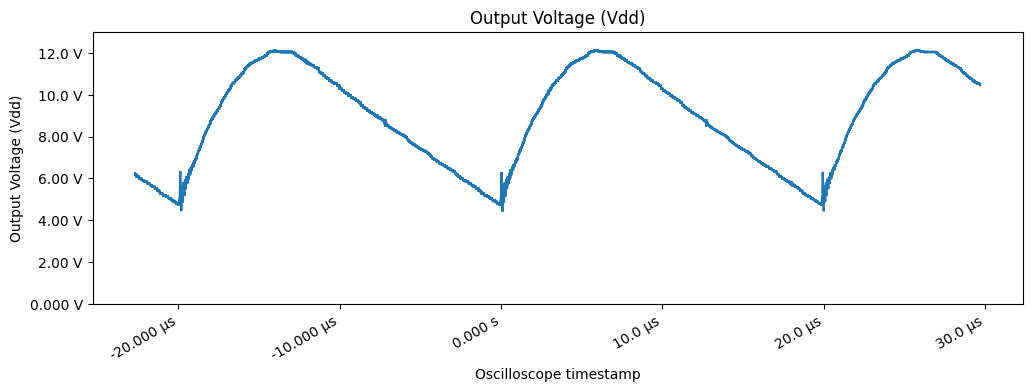

: 

In [15]:
# Vdd
df_envelope = df # df[(df["t"] > -2e-6) & (df["t"] < 2e-6)]
df_zoom = df[(df["t"] > -5e-6) & (df["t"] < 5e-6)]

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, sharex = False, sharey = True, figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "Output Voltage (Vdd)", "V", title = "Output Voltage (Vdd)", ax = ax1)
# ax1.plot(df_envelope["t"], df_envelope["Vdd_4V"], label = "Vdd_4V")
# ax1.plot(df_envelope["t"], df_envelope["Vdd_7V"], label = "Vdd_7V")
ax1.plot(df_envelope["t"], df_envelope["Vdd_9V"], label = "Vdd_9V")
# ax1.legend(loc = "lower left")
# ax1.annotate('1', xy=(-2.5e-6, 4), size=15, va="center", bbox=dict(boxstyle="round", fc="lightsteelblue", ec="none"))
# ax1.annotate('2', xy=(2e-6, 5.4), size=15, va="center", bbox=dict(boxstyle="round", fc="lightsteelblue", ec="none"))
# ax1.annotate('3', xy=(10.5e-6, 5.5), size=15, va="center", bbox=dict(boxstyle="round", fc="lightsteelblue", ec="none"))
ax1.set_ylim(0, 13)

Vdd = np.array([150e-3, 260e-3, 330e-3])
# ax1.axhline(y = Vout_vdd[0], color = "blue", linestyle = "dashed")
# ax1.axhline(y = Vout_vdd[1], color = "orange", linestyle = "dashed")
# ax1.axhline(y = Vout_vdd[2], color = "green", linestyle = "dashed")

linear_ts = (8e-6, 19.5e-6)
capacitances = []
for i, dataset in enumerate(["Vdd_4V", "Vdd_7V", "Vdd_9V"]):
    df_linreg = df[(df["t"] > linear_ts[0]) & (df["t"] < linear_ts[1])].dropna()

    x = df_linreg["t"]
    y = df_linreg[dataset]
    A = np.vstack([x, np.ones(len(x))]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]
    # ax1.plot(df_linreg["t"], df_linreg["t"] * a + b, linestyle = "dashdot", color = "black", label = ("Linear fit") if i == 0 else None)
    # ax1.legend(loc = "lower left")

    Vc = Vout_vdd[i]
    Ic = -Vc / Rload
    dVdt = a
    C = Ic / dVdt
    capacitances.append(C)
    print(f"Capacitance Value for {Vout_vdd[i]}V: {si_format(C, precision = 2)}F")

#### Same regions as before
* **Region 1:** Inductor is charging up from input power source Ig.
* **Region 2:** Inductor is discharging into output into load resistor and capacitor.
* **Region 3:** Inductor no longer discharging (ran out of current). Output voltage is maintained by capacitor.

There is a slight blip of noise between regions 3 and 1; otherwise, they are indistinguishable from the output voltage's perspective, since in either case no current is flowing through the inductor into the right hand side of the circuit.

In Regions 3 and 1, the capacitor is solely responsible for maintaining the output voltage. The inductor does not interact with the right hand part of the circuit, so the circuit simplifies to the output capacitor and load resistor in series. Thus, the current through the capacitor is equal to the load current, which is approximately constant at `I = Vout / Rload`.

The capacitance is experimentally found to be between 3uF and 5uF, with higher capacitances at lower output voltages. This seems quite low, but it tracks quite well with the simulated results.

## Simulation Comparison

![Updated flyback converter schematic configured for 9V output with 19.1uH inductor and 3.10uF capacitor](flyback_converter_schematic_2.png)
**Figure 2:** Updated flyback converter schematic configured for 9V output with 19.1uH inductor and 3.10uF capacitor. 

I only compared waveforms for the 9V measurements. They seem to track quite closely. The switching period is slightly different. Ringing occurs in the places described previously; ringing is not exhibited in the simulation.

The simulated drain voltage follows an interesting slow approach to the maximum plateau value during Region 2. The output voltage shows the start of an expected asymptotic approach towards 0V, which is not as apparent in the experimental waveform of Vdd.

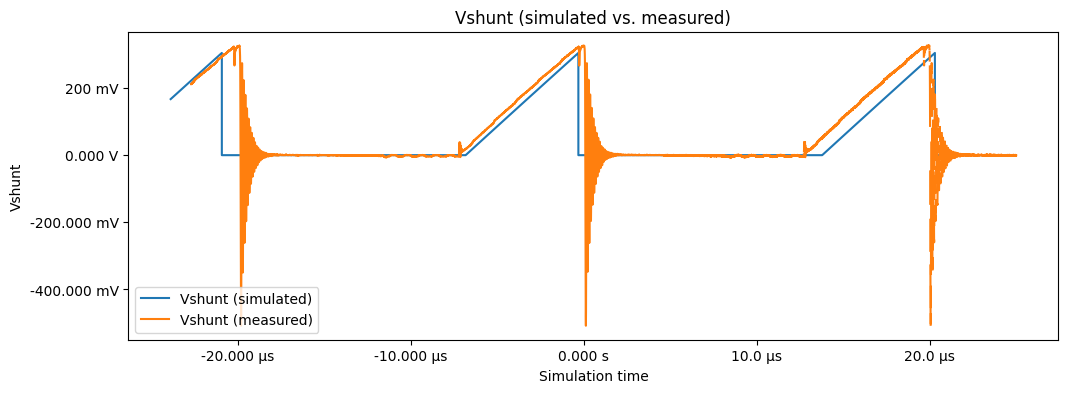

In [10]:
df_simulated = pd.read_csv("plecs_data/post_9V.csv")
df_simulated.rename(mapper = helper.strip_labels, axis = "columns", inplace = True)
df_simulated["t"] = df_simulated["t"] - 8e-3 - 9.5e-6
df_simulated_zoom = df_simulated.loc[(df_simulated["t"] > -25e-6) & (df_simulated["t"] < 25e-6)]
df_zoom = df.loc[(df["t"] > -25e-6) & (df["t"] < 25e-6)]

fig = plt.figure(figsize = (12, 4))
plt.plot(df_simulated_zoom["t"], df_simulated_zoom["V_Isense"], label = "Vshunt (simulated)")
plt.plot(df_zoom["t"], df_zoom["Vsh_9V"], label = "Vshunt (measured)")
helper.axes_labels("Simulation time", "s", "Vshunt", "V", title = "Vshunt (simulated vs. measured)")
plt.legend(loc = "lower left")

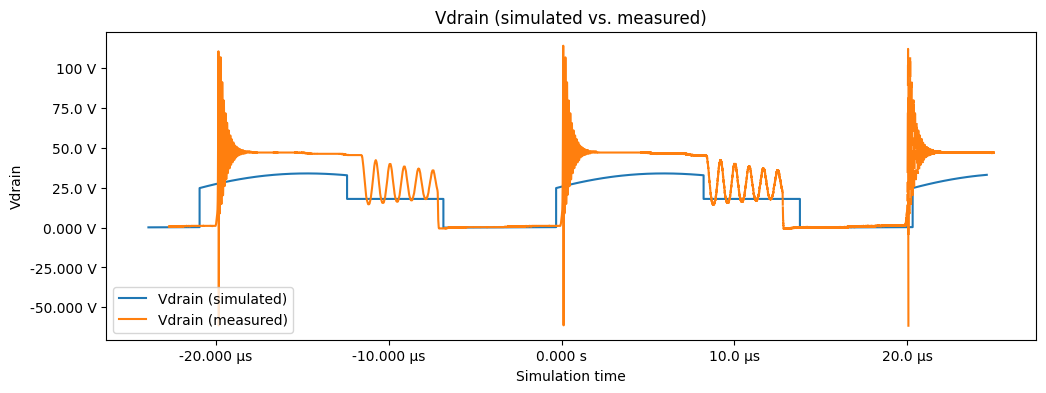

In [11]:
df_simulated = pd.read_csv("plecs_data/post_9V.csv")
df_simulated.rename(mapper = helper.strip_labels, axis = "columns", inplace = True)
df_simulated["t"] = df_simulated["t"] - 8e-3 - 9.5e-6
df_simulated_zoom = df_simulated.loc[(df_simulated["t"] > -25e-6) & (df_simulated["t"] < 25e-6)]
df_zoom = df.loc[(df["t"] > -25e-6) & (df["t"] < 25e-6)]

fig = plt.figure(figsize = (12, 4))
plt.plot(df_simulated_zoom["t"], df_simulated_zoom["Vdrain"], label = "Vdrain (simulated)")
plt.plot(df_zoom["t"], df_zoom["Vd_9V"], label = "Vdrain (measured)")
helper.axes_labels("Simulation time", "s", "Vdrain", "V", title = "Vdrain (simulated vs. measured)")
plt.legend(loc = "lower left")

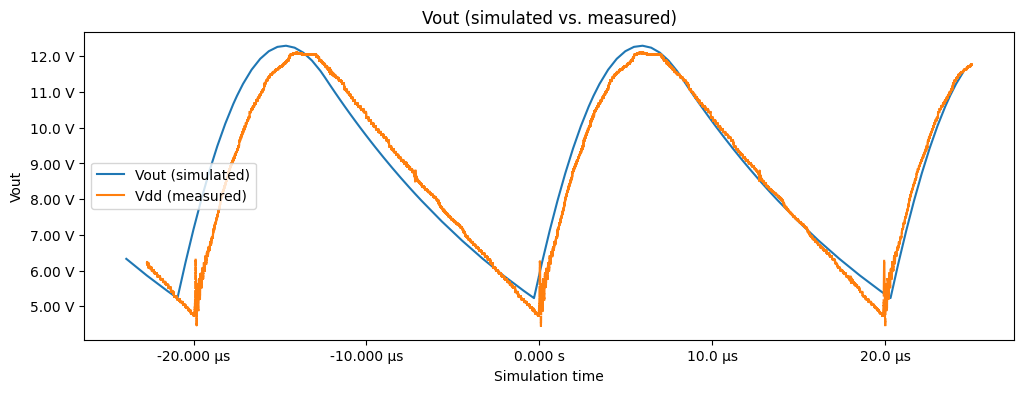

In [12]:
df_simulated = pd.read_csv("plecs_data/post_9V.csv")
df_simulated.rename(mapper = helper.strip_labels, axis = "columns", inplace = True)
df_simulated["t"] = df_simulated["t"] - 8e-3 - 9.5e-6
df_simulated_zoom = df_simulated.loc[(df_simulated["t"] > -25e-6) & (df_simulated["t"] < 25e-6)]
df_zoom = df.loc[(df["t"] > -25e-6) & (df["t"] < 25e-6)]

fig = plt.figure(figsize = (12, 4))
plt.plot(df_simulated_zoom["t"], df_simulated_zoom["Vout"], label = "Vout (simulated)")
plt.plot(df_zoom["t"], df_zoom["Vdd_9V"], label = "Vdd (measured)")
helper.axes_labels("Simulation time", "s", "Vout", "V", title = "Vout (simulated vs. measured)")
plt.legend(loc = "center left")